In [1]:
# 1) Installs / imports
!pip install -q tqdm    # usually preinstalled in Colab, but safe
from pathlib import Path
import os
import time
import math
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm

In [2]:
# 2) Config / paths
CSV_PATH = "/content/credit_card_fraud_processed.csv"   # <- change to your uploaded file or Drive path
RANDOM_SEED = 42
BATCH_SIZE = 1024
NUM_EPOCHS = 3
LEARNING_RATE = 1e-3
NUM_WORKERS = 4   # DataLoader multithreading; increase if you have many CPU cores
PIN_MEMORY = True

In [3]:
# 3) Utility: set seeds & device
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU name:", torch.cuda.get_device_name(0))
    except:
        pass

Device: cuda
CUDA available: True
GPU name: Tesla T4


In [4]:
# 4) Load CSV (either uploaded via Colab file uploader or from Drive)
if not Path(CSV_PATH).exists():
    # If not found, prompt user to upload interactively (Colab)
    from google.colab import files
    print("CSV not found at", CSV_PATH)
    print("Please upload your CSV now (choose the file from your machine)...")
    uploaded = files.upload()
    # take the first uploaded file
    CSV_PATH = list(uploaded.keys())[0]
    print("Using uploaded file:", CSV_PATH)

df = pd.read_csv(CSV_PATH, sep=None, engine='python')  # auto-detect separator
print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Loaded data shape: (339607, 15)
Columns: ['trans_date_trans_time', 'merchant', 'category', 'amt', 'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long', 'is_fraud', 'age']


,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age
0,2019-01-01 00:00:44,241,4,107.23,116,11,48.8878,-118.2105,149,139,1978-06-21,49.159047,-118.186462,0,42
1,2019-01-01 00:00:51,390,0,220.11,93,5,42.1808,-112.2620,4154,101,1962-01-19,43.150704,-112.154481,0,58
2,2019-01-01 00:07:27,308,4,96.29,51,2,41.6125,-122.5258,589,143,1945-12-21,41.657520,-122.230347,0,75


In [5]:
# 5) Feature selection - tailored to the dataset example you provided.
#    Adjust `feature_cols` if your CSV has different columns or more features.
# Example columns from your sample:
# "trans_date_trans_time merchant category amt city state lat long city_pop job dob merch_lat merch_long is_fraud age"
# We will drop datetime & DOB (already preprocessed 'age' present). Use all numeric columns except target.
TARGET_COL = "is_fraud"

# Try to infer numeric feature columns:
possible_features = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in possible_features:
    possible_features.remove(TARGET_COL)
feature_cols = possible_features

# If some columns are encoded as strings but numeric-coded (like "merchant" or "city"), convert:
for c in df.columns:
    if c not in [TARGET_COL] and df[c].dtype == object:
        # attempt numeric conversion
        try:
            df[c] = pd.to_numeric(df[c])
            if c not in feature_cols:
                feature_cols.append(c)
        except:
            # If cannot convert, drop or one-hot encode - here we drop to keep pipeline simple.
            print(f"Note: dropping non-numeric column '{c}'. If it's important, encode it before training.")
            df = df.drop(columns=[c])

print("Using features:", feature_cols)
print("Target:", TARGET_COL)
print("Class distribution:\n", df[TARGET_COL].value_counts(normalize=True))

Note: dropping non-numeric column 'trans_date_trans_time'. If it's important, encode it before training.
Note: dropping non-numeric column 'dob'. If it's important, encode it before training.
Using features: ['merchant', 'category', 'amt', 'city', 'state', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long', 'age']
Target: is_fraud
Class distribution:
 is_fraud
0    0.994753
1    0.005247
Name: proportion, dtype: float64


In [6]:
# 6) Train / val / test split
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df[TARGET_COL], random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df[TARGET_COL], random_state=RANDOM_SEED)

print("Sizes -> train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)

Sizes -> train: (245365, 13) val: (43300, 13) test: (50942, 13)


In [7]:
# 7) Scaling numeric features (StandardScaler). Fit on train only.
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])
train_X = scaler.transform(train_df[feature_cols]).astype(np.float32)
val_X   = scaler.transform(val_df[feature_cols]).astype(np.float32)
test_X  = scaler.transform(test_df[feature_cols]).astype(np.float32)

train_y = train_df[TARGET_COL].values.astype(np.int64)
val_y   = val_df[TARGET_COL].values.astype(np.int64)
test_y  = test_df[TARGET_COL].values.astype(np.int64)

In [8]:
# 8) PyTorch Dataset + DataLoader (uses workers for multithreading)
class FraudDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.long)

train_ds = FraudDataset(train_X, train_y)
val_ds = FraudDataset(val_X, val_y)
test_ds = FraudDataset(test_X, test_y)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256,128], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 2))  # binary classification (2 outputs for logits)
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=len(feature_cols), hidden_dims=[512,256,128], dropout=0.25).to(device)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)


In [13]:
# 11) Training loop with mixed precision (AMP) and timing
scaler_amp = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def evaluate(loader, model):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            if device.type == "cuda":
                Xb = Xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
            out = model(Xb)
            pred = torch.softmax(out, dim=1)[:,1].detach().cpu().numpy()
            preds.append(pred)
            trues.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    # threshold 0.5
    bin_preds = (preds >= 0.5).astype(int)
    acc = accuracy_score(trues, bin_preds)
    prec = precision_score(trues, bin_preds, zero_division=0)
    rec = recall_score(trues, bin_preds, zero_division=0)
    f1 = f1_score(trues, bin_preds, zero_division=0)
    try:
        auc = roc_auc_score(trues, preds)
    except:
        auc = float("nan")
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

best_val_f1 = -1.0
history = {"train_loss":[], "val_f1":[]}

print("Starting training...")
start_time_all = time.perf_counter()
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    start_epoch = time.perf_counter()
    for Xb, yb in progress:
        if device.type == "cuda":
            Xb = Xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        # mixed precision forward/backward
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(Xb)
            loss = criterion(logits, yb)
        if torch.cuda.is_available():
            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        epoch_loss += loss.item() * Xb.size(0)
        avg_loss = epoch_loss / len(train_loader.dataset)
        progress.set_postfix({"loss": f"{avg_loss:.5f}"})
    end_epoch = time.perf_counter()

    # Validation
    val_metrics = evaluate(val_loader, model)
    history["train_loss"].append(avg_loss)
    history["val_f1"].append(val_metrics["f1"])
    scheduler.step(val_metrics["f1"])

    print(f"Epoch {epoch} finished in {end_epoch-start_epoch:.1f}s - train_loss: {avg_loss:.5f}  val_f1: {val_metrics['f1']:.4f}  val_auc: {val_metrics['auc']:.4f}")
    # Save best
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        torch.save(model.state_dict(), "best_mlp_fraud.pth")
        print("Saved best model (f1):", best_val_f1)

end_time_all = time.perf_counter()
print(f"Total training time: {end_time_all - start_time_all:.2f} seconds")

Starting training...


/tmp/ipython-input-2801198011.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/3:   0%|          | 0/240 [00:00<?, ?it/s]

/tmp/ipython-input-2801198011.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1 finished in 6.8s - train_loss: 0.04489  val_f1: 0.0000  val_auc: 0.9008
Saved best model (f1): 0.0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/3:   0%|          | 0/240 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()
    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloade

Epoch 2 finished in 5.4s - train_loss: 0.02011  val_f1: 0.1628  val_auc: 0.8912
Saved best model (f1): 0.16279069767441862


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/3:   0%|          | 0/240 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340><function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340><function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340><function _MultiProcessingDataLoaderIter.__del__ at 0x7bd53e5ce340>
Traceback (most recent call last):



  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()Traceback (most recent call last):
        
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()  F

Epoch 3 finished in 8.8s - train_loss: 0.01875  val_f1: 0.5293  val_auc: 0.9142
Saved best model (f1): 0.5292740046838408
Total training time: 28.83 seconds


In [14]:
import time
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Force CPU device
device = torch.device("cpu")
print("Using device:", device)

# Reuse FraudDataset, train/val/test sets from GPU pipeline
# Only rebuild DataLoaders with multithreading
NUM_WORKERS = 8   # try 2x-4x your CPU core count for best performance
BATCH_SIZE = 1024

train_loader_cpu = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=False)
val_loader_cpu   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)
test_loader_cpu  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)

Using device: cpu


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
# Define model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512,256,128], dropout=0.25):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 2))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_cpu = MLP(input_dim=len(feature_cols)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_cpu.parameters(), lr=1e-3, weight_decay=1e-5)

In [16]:
def train_cpu(model, train_loader, val_loader, epochs=3):
    best_val_f1 = -1
    history = []
    start_time = time.perf_counter()
    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * Xb.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)

        # Validation
        val_metrics = evaluate(val_loader, model)
        history.append(val_metrics)

        print(f"Epoch {epoch}/{epochs} - train_loss: {avg_loss:.4f} "
              f"val_f1: {val_metrics['f1']:.4f} val_auc: {val_metrics['auc']:.4f}")

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            torch.save(model.state_dict(), "best_mlp_cpu.pth")
            print("Saved best CPU model (f1):", best_val_f1)

    end_time = time.perf_counter()
    print(f"\nTotal CPU training time: {end_time - start_time:.2f} seconds")
    return history

# Run CPU training
history_cpu = train_cpu(model_cpu, train_loader_cpu, val_loader_cpu, epochs=3)

Epoch 1/3 - train_loss: 0.0617 val_f1: 0.0087 val_auc: 0.8949
Saved best CPU model (f1): 0.008733624454148471


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/3 - train_loss: 0.0213 val_f1: 0.0000 val_auc: 0.8914


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/3 - train_loss: 0.0194 val_f1: 0.2411 val_auc: 0.9109
Saved best CPU model (f1): 0.24113475177304963

Total CPU training time: 34.63 seconds


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cpu] Epoch 1 - loss: 0.0645 val_f1: 0.0972 val_auc: 0.8979


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cpu] Epoch 2 - loss: 0.0214 val_f1: 0.3647 val_auc: 0.8910


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cpu] Epoch 3 - loss: 0.0193 val_f1: 0.2324 val_auc: 0.8971


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



CPU Test metrics: {'acc': 0.9946213340661929, 'prec': 0.4700854700854701, 'rec': 0.20599250936329588, 'f1': 0.2864583333333333, 'auc': np.float64(0.8595945004610048)}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cuda] Epoch 1 - loss: 0.0438 val_f1: 0.0667 val_auc: 0.8918


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cuda] Epoch 2 - loss: 0.0202 val_f1: 0.3670 val_auc: 0.8868


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2429114911.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[cuda] Epoch 3 - loss: 0.0184 val_f1: 0.4912 val_auc: 0.9018


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



GPU Test metrics: {'acc': 0.995367280436575, 'prec': 0.5865921787709497, 'rec': 0.39325842696629215, 'f1': 0.47085201793721976, 'auc': np.float64(0.8924938794439856)}


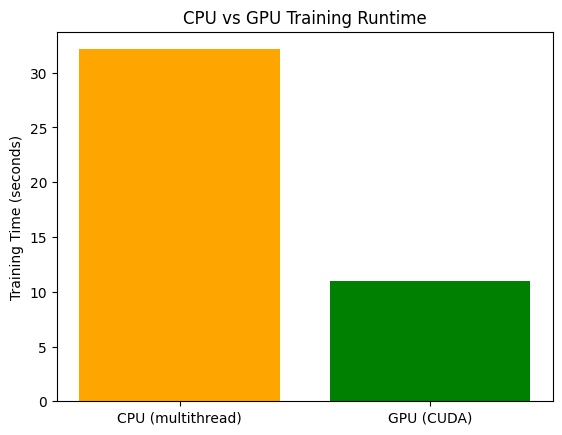


Comparison Table:
           CPU       GPU
acc   0.994621  0.995367
prec  0.470085  0.586592
rec   0.205993  0.393258
f1    0.286458  0.470852
auc   0.859595  0.892494


In [19]:
import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# -----------------------------
# Model definition
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512,256,128], dropout=0.25):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 2))  # 2 classes (fraud / not fraud)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# -----------------------------
# Training function
# -----------------------------
def train_model(model, loader, val_loader, device, epochs=3, use_amp=False):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)
    best_val_f1 = -1
    start_time = time.perf_counter()

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        for Xb, yb in loader:
            # ✅ move batch to the correct device
            Xb = Xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad()
            # AMP for GPU, disabled for CPU
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(Xb)
                loss = criterion(logits, yb)

            if use_amp:
                scaler_amp.scale(loss).backward()
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item() * Xb.size(0)

        avg_loss = epoch_loss / len(loader.dataset)
        val_metrics = evaluate(val_loader, model, device)
        print(f"[{device}] Epoch {epoch} - loss: {avg_loss:.4f} "
              f"val_f1: {val_metrics['f1']:.4f} val_auc: {val_metrics['auc']:.4f}")

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            torch.save(model.state_dict(), f"best_mlp_{device}.pth")

    end_time = time.perf_counter()
    runtime = end_time - start_time
    return runtime

# -----------------------------
# Evaluation function (device-safe)
# -----------------------------
def evaluate(loader, model, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            out = model(Xb)
            prob = torch.softmax(out, dim=1)[:,1].detach().cpu().numpy()
            preds.append(prob)
            trues.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    bin_preds = (preds >= 0.5).astype(int)
    acc  = accuracy_score(trues, bin_preds)
    prec = precision_score(trues, bin_preds, zero_division=0)
    rec  = recall_score(trues, bin_preds, zero_division=0)
    f1   = f1_score(trues, bin_preds, zero_division=0)
    auc  = roc_auc_score(trues, preds) if len(np.unique(trues)) > 1 else float("nan")
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

# ==================================================
# 1) CPU (multithreaded DataLoader)
# ==================================================
device_cpu = torch.device("cpu")
train_loader_cpu = DataLoader(train_ds, batch_size=1024, shuffle=True,
                              num_workers=8, pin_memory=False)
val_loader_cpu   = DataLoader(val_ds, batch_size=1024, shuffle=False,
                              num_workers=8, pin_memory=False)
test_loader_cpu  = DataLoader(test_ds, batch_size=1024, shuffle=False,
                              num_workers=8, pin_memory=False)

model_cpu = MLP(input_dim=len(feature_cols))
time_cpu = train_model(model_cpu, train_loader_cpu, val_loader_cpu,
                       device_cpu, epochs=3, use_amp=False)

# Evaluate CPU model
model_cpu.load_state_dict(torch.load("best_mlp_cpu.pth", map_location=device_cpu))
test_metrics_cpu = evaluate(test_loader_cpu, model_cpu, device_cpu)
print("\nCPU Test metrics:", test_metrics_cpu)

# ==================================================
# 2) GPU (CUDA + AMP) if available
# ==================================================
if torch.cuda.is_available():
    device_gpu = torch.device("cuda")
    train_loader_gpu = DataLoader(train_ds, batch_size=1024, shuffle=True,
                                  num_workers=4, pin_memory=True)
    val_loader_gpu   = DataLoader(val_ds, batch_size=1024, shuffle=False,
                                  num_workers=4, pin_memory=True)
    test_loader_gpu  = DataLoader(test_ds, batch_size=1024, shuffle=False,
                                  num_workers=4, pin_memory=True)

    model_gpu = MLP(input_dim=len(feature_cols))
    time_gpu = train_model(model_gpu, train_loader_gpu, val_loader_gpu,
                           device_gpu, epochs=3, use_amp=True)

    # Evaluate GPU model
    model_gpu.load_state_dict(torch.load("best_mlp_cuda.pth", map_location=device_gpu))
    test_metrics_gpu = evaluate(test_loader_gpu, model_gpu, device_gpu)
    print("\nGPU Test metrics:", test_metrics_gpu)
else:
    print("CUDA not available in this runtime.")
    time_gpu = None
    test_metrics_gpu = {}

# ==================================================
# Runtime Comparison (Bar chart)
# ==================================================
labels = ["CPU (multithread)", "GPU (CUDA)"]
times = [time_cpu, time_gpu if time_gpu is not None else 0]

plt.bar(labels, times, color=["orange", "green"])
plt.ylabel("Training Time (seconds)")
plt.title("CPU vs GPU Training Runtime")
plt.show()

# ==================================================
# Metrics Comparison (Table)
# ==================================================
import pandas as pd

results = {
    "CPU": test_metrics_cpu,
    "GPU": test_metrics_gpu if test_metrics_gpu else {"acc":0,"prec":0,"rec":0,"f1":0,"auc":0}
}
df_results = pd.DataFrame(results)
print("\nComparison Table:")
print(df_results)
